In [1]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from biokit.viz import corrplot

In [2]:
def tsne_viz(dados, agrupador, padronizador=StandardScaler()):
    """Faz uma visualização do agrupador em duas dimensões, por meio da redução do algoritmo TSNE
    
    Args:
        dados (DataFrame): dataset de entrada
        agrupador (scikit cluster): agrupador (clusterizador) a usar
        padronizador (scikit scaler): padronizador para os dados de input
    """
    # Usando o padronizador Standard Scaler
    padronizador.fit(dados)
    
    # Transformando os dados iniciais e retornando a um DataFrame do pandas
    dados_tsne_np = padronizador.transform(dados)
    dados_tsne_pd = pd.DataFrame(dados_tsne_np, columns=dados.columns)
    
    # Instanciando o TSNE para duas dimensões
    tsne = TSNE(n_components=2)
    tsne_np = tsne.fit_transform(dados_tsne_pd)
    
    # Ajustando o agrupador
    agrupador.fit(dados_tsne_pd)
    
    # Label referente a cada entrada do dataset (cluster ao qual o vinho pertence)
    labels = agrupador.labels_
    
    # Visualização:
    fig = px.scatter(x=tsne_np[:,0], y=tsne_np[:,1], color=labels.astype(str))
    #fig = go.Figure()
    #fig.add_trace(go.Scatter(x=tsne_np[:,0], y=tsne_np[:,1],
    #                           mode='markers', 
    #                           marker={'color': labels.astype(float)+ 10 , 'size': 8},
    #                           text=['Grupo 0', 'Grupo 1'], )
    #             )
    fig.update_layout(
        title={'text': f'{sum(np.unique(labels) != -1)} Clusters em 2 dimensões, com redução de dimensionalidade', 'x': 0.5},
        legend_title_text='Cluster',
        xaxis_title='Dimensão 1',
        yaxis_title='Dimensão 2'
    )
    fig.show('png')
    
    pass

# 01. Análise exploratória 

In [3]:
# Carregamento dos dados
URI = 'https://raw.githubusercontent.com/alura-cursos/Clustering/Aula-1.-An%C3%A1lise-Explorat%C3%B3ria/Wine.csv'
dados = pd.read_csv(URI)
dados.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


In [4]:
# Valor pra 'Customer_Segment' não ajuda na classficação, que parece ter caráter químico;
dados = dados.drop(columns=['Customer_Segment'])

# Tradução das colunas
dados = dados.rename(columns={
    'Alcohol': 'alcool',
    'Malic_Acid': 'acido_malico',
    'Ash': 'po',
    'Ash_Alcanity': 'alcalinidade_po',
    'Magnesium': 'magnesio',
    'Total_Phenols': 'fenois_totais',
    'Flavanoids': 'flavonoides',
    'Nonflavanoid_Phenols': 'fenois_nao_flavonoides',
    'Proanthocyanins': 'proantocianidinas',
    'Color_Intensity': 'intensidade_cor',
    'Proline': 'prolina',
})

dados.head()

,alcool,acido_malico,po,alcalinidade_po,magnesio,fenois_totais,flavonoides,fenois_nao_flavonoides,proantocianidinas,intensidade_cor,Hue,OD280,prolina
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


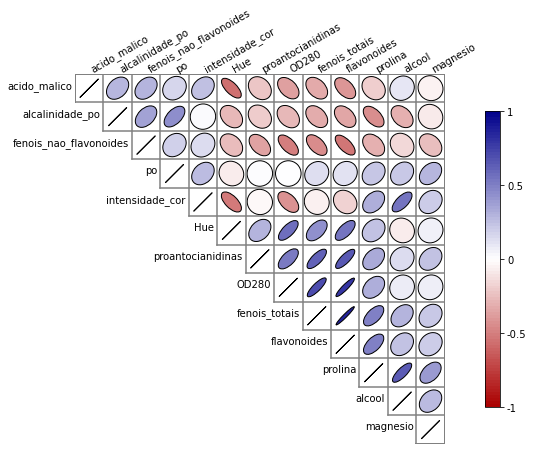

In [5]:
# Matriz de correlação 
mat_corr = dados.corr()

# Visualização 
graf_corr = corrplot.Corrplot(mat_corr)
graf_corr.plot(upper='ellipse', fontsize='medium')

fig = plt.gcf()
fig.set_size_inches((14,8))

In [6]:
# Padronização dos dados
min_max_scaler = MinMaxScaler()
minmax_data_np = min_max_scaler.fit_transform(dados)

minmax_data = pd.DataFrame(minmax_data_np, columns=dados.columns)
minmax_data.head()

,alcool,acido_malico,po,alcalinidade_po,magnesio,fenois_totais,flavonoides,fenois_nao_flavonoides,proantocianidinas,intensidade_cor,Hue,OD280,prolina
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


# 02. K-Means

(178,)


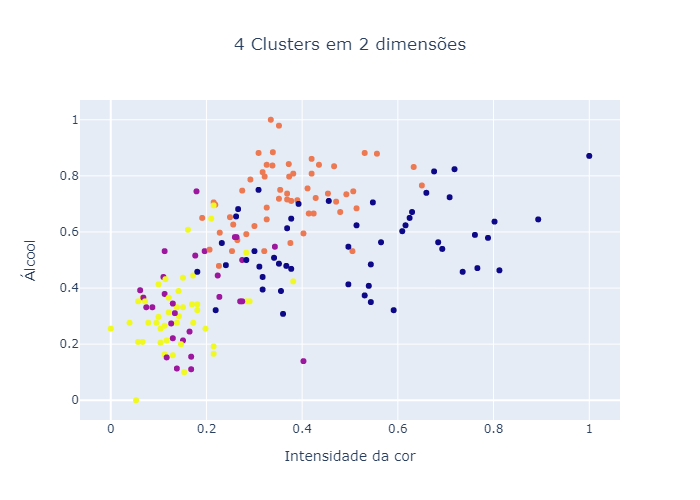

In [7]:
# Com 4 grupos: 
agrupador = KMeans(n_clusters=4)
agrupador.fit(minmax_data)

# Label referente a cada entrada do dataset (cluster ao qual o vinho pertence)
labels = agrupador.labels_
print(labels.shape)

# Visualização em duas dimensões
fig = go.Figure()
fig.add_trace(go.Scatter(x=minmax_data.intensidade_cor, y=minmax_data.alcool, mode='markers', 
                         marker={'color': labels.astype(float)}, text=labels)
             )
fig.update_layout(
    title={'text': '4 Clusters em 2 dimensões', 'x': 0.5},
    xaxis_title='Intensidade da cor',
    yaxis_title='Álcool'
)
fig.show('png')

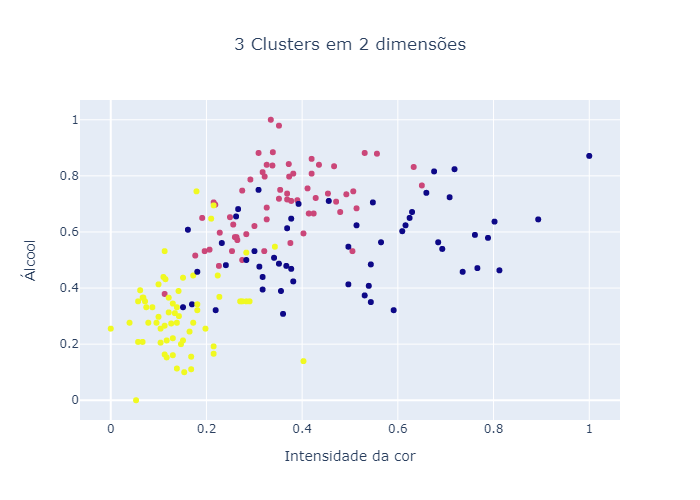

In [8]:
# Com 3 grupos: 
agrupador = KMeans(n_clusters=3)
agrupador.fit(minmax_data)

# Label referente a cada entrada do dataset (cluster ao qual o vinho pertence)
labels = agrupador.labels_

# Visualização em duas dimensões
fig = go.Figure()
fig.add_trace(go.Scatter(x=minmax_data.intensidade_cor, y=minmax_data.alcool, mode='markers', 
                         marker={'color': labels.astype(float)}, text=labels)
             )
fig.update_layout(
    title={'text': '3 Clusters em 2 dimensões', 'x': 0.5},
    xaxis_title='Intensidade da cor',
    yaxis_title='Álcool'
)
fig.show('png')

(178,)


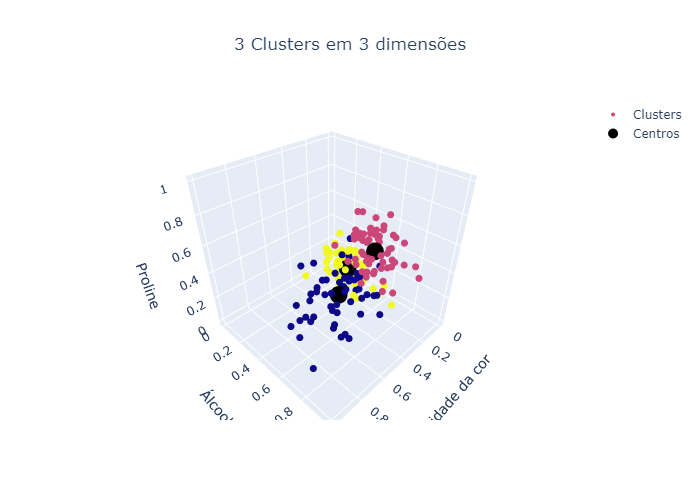

In [9]:
# Agora, 3 grupos em 3 dimensões
agrupador = KMeans(n_clusters=3)
agrupador.fit(minmax_data)

# Label referente a cada entrada do dataset (cluster ao qual o vinho pertence)
labels = agrupador.labels_
print(labels.shape)

# Visualização em duas dimensões
fig = go.Figure()
fig.add_trace(go.Scatter3d(x=minmax_data.intensidade_cor, y=minmax_data.alcool, z=minmax_data.prolina,
                           mode='markers', 
                           marker={'color': labels.astype(float), 'size': 4},
                           text=['Grupo 0', 'Grupo 1', 'Grupo 2'], 
                           name='Clusters')
             )
fig.update_layout(scene={'xaxis_title':'Intensidade da cor', 'yaxis_title':'Álcool', 
                         'zaxis_title':'Proline'}, 
                  title={'text': '3 Clusters em 3 dimensões', 'x': 0.5})

# Adicionando os centros de cada cluster :
centros = pd.DataFrame(agrupador.cluster_centers_)
centros.columns = minmax_data.columns

fig.add_trace(go.Scatter3d(x=centros.intensidade_cor, y=centros.alcool, z=centros.prolina, 
                           mode='markers', 
                           marker={'color': 'black', 'size': 10},
                           name='Centros'
                          ))
fig.show('png')

Apesar de não mostrado no curso, uma alternativa possível seria a visualização por meio de um dos algoritmos de redução de dimensionalização (mostrada no curso anterior). Como desvantagem, tem-se que as dimensões resultantes do algoritmo são abstratas (numéricas) em contraponto ao significado químico/visual das features iniciais. A visualização foi gerada abaixo e seu sucesso em separar os clusters é realmente mais perceptível.

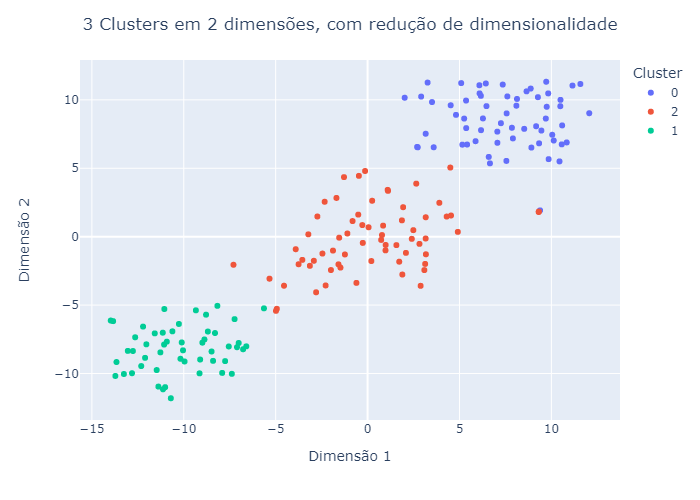

In [10]:
tsne_viz(dados, agrupador = KMeans(n_clusters=3))

# 03. DBSCAN

,Valores,Contagem
0,-1,29
1,0,104
2,1,45


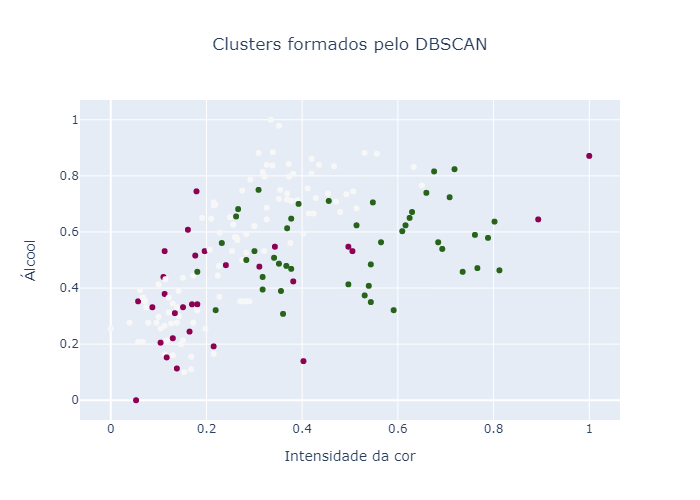

In [11]:
# eps --> 'distância máxima' entre pontos dentro de um mesmo cluster
# min_samples --> mínimo de pontos para definição de um cluster
agrupador = DBSCAN(eps=1.5, min_samples=15, metric='manhattan')
agrupador.fit(minmax_data)

labels = agrupador.labels_
# Para contar os valores
display(pd.DataFrame(np.unique(labels, return_counts=True),
                     index=['Valores', 'Contagem']).transpose())

# Visualização 2D
fig = go.Figure()
fig.add_trace(go.Scatter(x=minmax_data.intensidade_cor, y=minmax_data.alcool, mode='markers', 
                         marker={'color': labels.astype(float)}, text=labels)
             )
fig.update_layout(
    title={'text': 'Clusters formados pelo DBSCAN', 'x': 0.5},
    xaxis_title='Intensidade da cor',
    yaxis_title='Álcool'
)
fig.show('png')

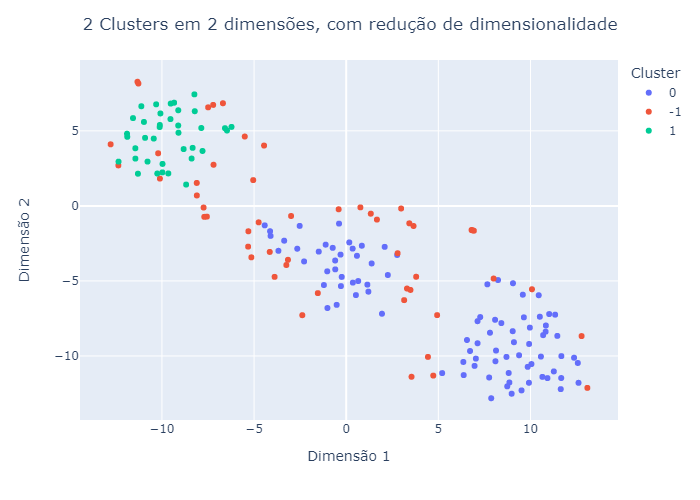

In [12]:
# Da mesma forma, visualizando pelo TSNE:
tsne_viz(dados, DBSCAN(eps=1.4, min_samples=15, metric='manhattan'), padronizador=MinMaxScaler())

Para o DBSCAN, o 'cluster' com a tag -1 significa que o ponto na verdade não foi encaixado em cluster algum. Ou seja, não cumpriu com os requisitos comentados no começo da seção. Na visualização sem redução de dimensionalidade, todos os clusters parecem entrelaçados.

# 04. Mean shift

In [13]:
# Para o valor de bandwidth padrão
agrupador = MeanShift().fit(dados)
print(f'{sum(np.unique(agrupador.labels_) != -1)} clusters.')

3 clusters.


In [14]:
# Para diferentes valores de bw, por meio da função que estima bandwidth:

bw1 = estimate_bandwidth(dados, quantile=0.1)
bw2 = estimate_bandwidth(dados, quantile=0.15)
bw3 = estimate_bandwidth(dados, quantile=0.25)
bw4 = estimate_bandwidth(dados, quantile=0.35)
bw5 = estimate_bandwidth(dados, quantile=0.50)

agrupador = MeanShift(bandwidth=bw1).fit(dados)
print(f'{sum(np.unique(agrupador.labels_) != -1)} clusters, com bw = {bw1}.')

agrupador = MeanShift(bandwidth=bw2).fit(dados)
print(f'{sum(np.unique(agrupador.labels_) != -1)} clusters, com bw = {bw2}.')

agrupador = MeanShift(bandwidth=bw3).fit(dados)
print(f'{sum(np.unique(agrupador.labels_) != -1)} clusters, com bw = {bw3}.')

agrupador = MeanShift(bandwidth=bw4).fit(dados)
print(f'{sum(np.unique(agrupador.labels_) != -1)} clusters, com bw = {bw4}.')

agrupador = MeanShift(bandwidth=bw5).fit(dados)
print(f'{sum(np.unique(agrupador.labels_) != -1)} cluster, com bw = {bw5}.')

11 clusters, com bw = 63.17520286363913.
8 clusters, com bw = 97.395004928062.
4 clusters, com bw = 156.32473271797423.
2 clusters, com bw = 222.55680091752743.
1 cluster, com bw = 309.00048685760703.


# 05. Coeficiente de silhueta para avaliação de clusterizações

In [15]:
np.random.seed(333)

# Coeficientes para o KMeans (variação do número de clusters)
num_lst = list(range(2, 20))
silhueta_kmeans = []
for num_clusters in num_lst:
    labels = KMeans(n_clusters=num_clusters).fit_predict(minmax_data)
    media_silhueta = silhouette_score(minmax_data, labels)
    silhueta_kmeans.append(media_silhueta)
        
# Coeficientes para o DBSCAN (variação simultânea do eps e min_samples)
eps_lst = np.linspace(0.5, 10, 50)
min_samples_lst = range(2, 30)
silhueta_dbscan = []
eps_samples = []
num_clusters_dbscan = []
for eps in eps_lst:
    for min_samples in min_samples_lst:
        labels = DBSCAN(eps=eps, min_samples=min_samples, metric='manhattan').fit_predict(minmax_data)
        if (len(np.unique(labels)) > 1) and (len(np.unique(labels)) < minmax_data.shape[0]):
            media_silhueta = silhouette_score(minmax_data, labels)
            silhueta_dbscan.append(media_silhueta)
            eps_samples.append((eps, min_samples))
            num_clusters_dbscan.append(len(np.unique(labels)))
            
dbscan_df = pd.concat([pd.DataFrame(eps_samples, columns=['eps', 'min_samples']),
                       pd.DataFrame(silhueta_dbscan, columns=['silhueta_dbscan']),
                       pd.DataFrame(num_clusters_dbscan, columns=['num_clusters'])
                      ], axis=1)
dbscan_df['razao'] = dbscan_df.min_samples/dbscan_df.eps
            
# Coeficientes para o MeanShift (variação do bandwidth por meio dos quantis da função estimate bandwidth)
quantile = np.linspace(0.02, 1.00, 100)
quantile_plot = []
silhueta_meanshift = []
num_clusters_meanshift = []
for Q in quantile:
    labels = MeanShift(bandwidth=estimate_bandwidth(minmax_data, quantile=Q)).fit_predict(minmax_data)
    if (len(np.unique(labels)) > 1) and (len(np.unique(labels)) < minmax_data.shape[0]):
        media_silhueta = silhouette_score(minmax_data, labels)
        silhueta_meanshift.append(media_silhueta)
        quantile_plot.append(Q)
        num_clusters_meanshift.append(len(np.unique(labels)))

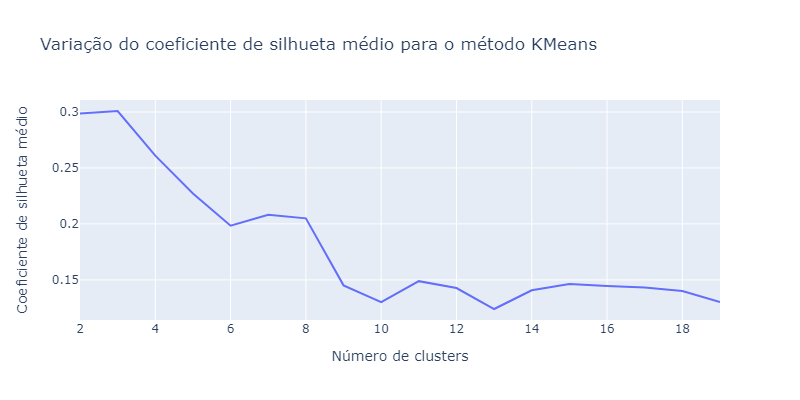

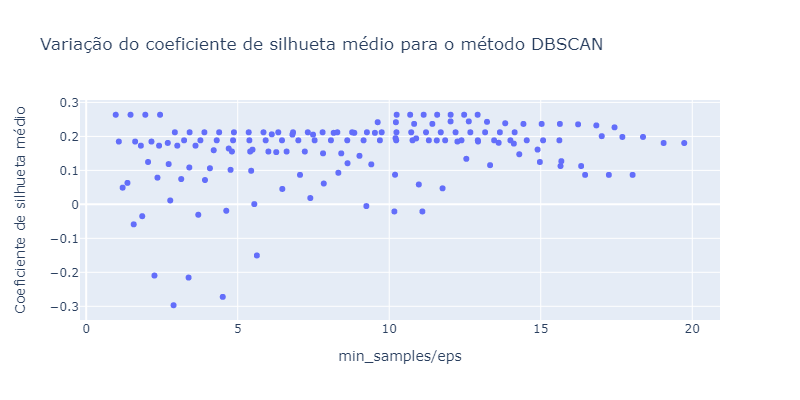

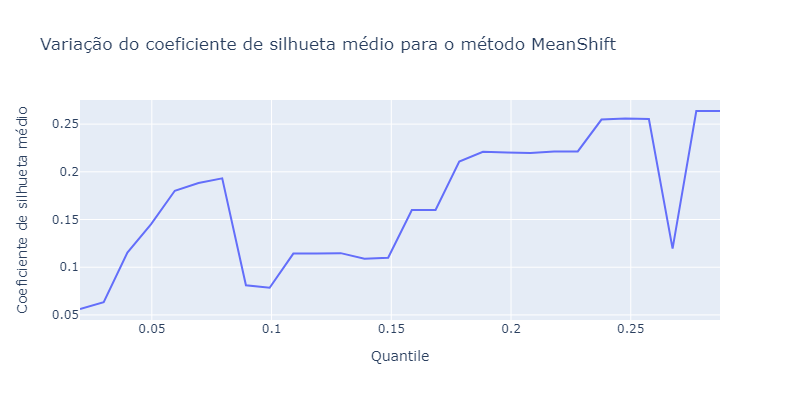

In [16]:
# Plot KMeans
plot_kmeans = px.line(x=num_lst, y=silhueta_kmeans, width=800, height=400,
                      title='Variação do coeficiente de silhueta médio para o método KMeans')
plot_kmeans.update_layout(xaxis_title='Número de clusters', yaxis_title='Coeficiente de silhueta médio')

# Plot DBSCAN
plot_dbscan = px.scatter(x=dbscan_df.razao, y=dbscan_df.silhueta_dbscan, width=800, height=400,
                      title='Variação do coeficiente de silhueta médio para o método DBSCAN')
plot_dbscan.update_layout(xaxis_title='min_samples/eps', yaxis_title='Coeficiente de silhueta médio')

# Plot MeanShift
plot_meanshift = px.line(x=quantile_plot, y=silhueta_meanshift, width=800, height=400,
                         title='Variação do coeficiente de silhueta médio para o método MeanShift')
plot_meanshift.update_layout(xaxis_title='Quantile', yaxis_title='Coeficiente de silhueta médio')

# Mostrar os plots
plot_kmeans.show('png')
plot_dbscan.show('png')
plot_meanshift.show('png')

In [17]:
# Valores máximos de coeficiente de silhueta
print(f"""KMeans: coeficiente de silhueta máximo de {round(max(silhueta_kmeans), 4)} com {num_lst[np.argmax(silhueta_kmeans)]} clusters.""")

print(f"""DBSCAN: coeficiente de silhueta máximo de {round(dbscan_df.silhueta_dbscan.max(), 4)} com eps = {round(dbscan_df.iloc[np.argmax(dbscan_df.silhueta_dbscan)].eps, 2)}, min_samples = {int(dbscan_df.iloc[np.argmax(dbscan_df.silhueta_dbscan)].min_samples)} e {int(dbscan_df.iloc[np.argmax(dbscan_df.silhueta_dbscan)].num_clusters)} clusters.""")

print(f"""MeanShift: coeficiente de silhueta máximo de {round(max(silhueta_meanshift), 4)} com {num_clusters_meanshift[np.argmax(silhueta_meanshift)]} clusters.""")

KMeans: coeficiente de silhueta máximo de 0.3009 com 3 clusters.
DBSCAN: coeficiente de silhueta máximo de 0.2638 com eps = 2.05, min_samples = 2 e 2 clusters.
MeanShift: coeficiente de silhueta máximo de 0.2638 com 2 clusters.


Seria de interesse escolher aquele com o maior coeficiente de silhueta. Como verificação, checar as labels geradas pelo agrupador para garantir que os clusters não estão estranhos. Aqui, já foi filtrado para que o 'cluster -1' não fosse exibido.